In [1]:
from tqdm import tqdm
import gc
import pickle
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

In [2]:
train_df = pl.read_parquet(
    "data/raw/train.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [3]:
test_df = pl.read_parquet(
    "data/raw/test.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [4]:
print(train_df.columns)

['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X13

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/293337480.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(train_df.columns)


Text(0.5, 1.0, 'Label Distribution')

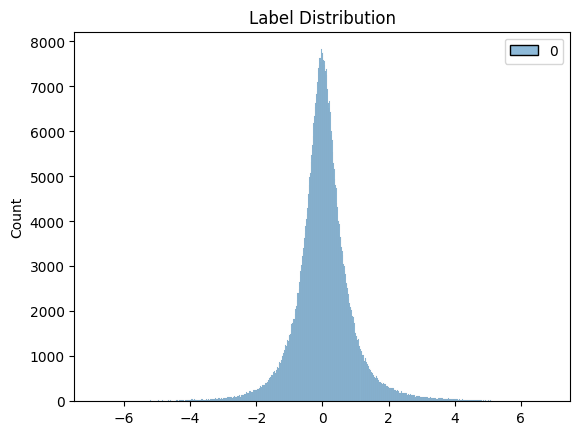

In [5]:
sns.histplot(train_df.select("label").collect().to_numpy())
plt.xlim([-7.5, 7.5])
plt.title("Label Distribution")

In [6]:
# drop timestamp since test data does not have timestamp
train_df = train_df.drop("timestamp")

In [7]:
# Check for nas in train or test
temp = train_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col

[]

In [8]:
temp = test_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col
# no nas issue in train and test

[]

In [9]:
# check all possible datatypes
print(set(train_df.dtypes))

{Float64}


/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/1737341288.py:2: PerformanceWarning: Determining the data types of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().dtypes()` to get the data types without this warning.
  print(set(train_df.dtypes))


In [10]:
# check for possible constant columns
constant_columns = []
for col in train_df.columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        constant_columns.append(col)
print(constant_columns)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/2295361549.py:3: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col in train_df.columns:


['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


In [11]:
# check if same issue might also appear in test
actual_constant_columns = []
for col in constant_columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        actual_constant_columns.append(col)
print(set(constant_columns) - set(actual_constant_columns)) # all are constant => can remove?

set()


In [12]:
train_df = train_df.drop(actual_constant_columns)

In [13]:
# # get columns pair that is perfectly (or very highly) correlated
# correlated_pair = []
# col_names = train_df.collect_schema().names()
# for i in tqdm(range(len(col_names) - 1)):
#     col1 = col_names[i]
#     if col1 not in constant_columns:
#         for j in range(i + 1, len(col_names)):
#             col2 = col_names[j]
#             if col2 not in constant_columns:
#                 x = train_df.select(col1).collect()[col1].to_numpy()
#                 y = train_df.select(col2).collect()[col2].to_numpy()
#                 if np.corrcoef(x, y)[0][1] == 1:
#                     correlated_pair.append(f"{col1}-{col2}")
# print(correlated_pair)
# print(len(correlated_pair))

In [14]:
correlated_pair = ['X62-X104', 'X62-X146', 'X74-X116', 'X74-X158', 'X86-X128', 'X86-X170', 'X92-X134', 'X92-X176', 'X98-X140', 'X98-X182', 'X104-X146', 'X116-X158', 'X128-X170', 'X134-X176', 'X140-X182', 'X315-X357', 'X315-X399', 'X321-X363', 'X321-X405', 'X327-X369', 'X327-X411', 'X333-X375', 'X333-X417', 'X339-X381', 'X339-X423', 'X357-X399', 'X363-X405', 'X369-X411', 'X375-X417', 'X381-X423']
actual_correlated_pair = []
for cp in correlated_pair:
    col1, col2 = cp.split("-")
    x = test_df.select(col1).collect()[col1].to_numpy()
    y = test_df.select(col2).collect()[col2].to_numpy()
    if np.corrcoef(x, y)[0][1] == 1:
        actual_correlated_pair.append(f"{col1}-{col2}")
set(correlated_pair) - set(actual_correlated_pair)

{'X140-X182', 'X321-X363', 'X321-X405', 'X363-X405', 'X98-X140', 'X98-X182'}

In [15]:
# Group into correlated group
correlated_group = []
for cp in actual_correlated_pair:
    cp_lst = cp.split("-")
    added = False
    for inx, cg in enumerate(correlated_group):
        for var in cp_lst:
            if var in cg:
                correlated_group[inx].extend(cp_lst)
                correlated_group[inx] = list(set(correlated_group[inx]))
                added = True
                break
        if added:
            break
    if not added:
        correlated_group.append(cp_lst)
correlated_group
# 8 groups of perfectly correlated features, try to check if same things happen in test

[['X146', 'X104', 'X62'],
 ['X74', 'X158', 'X116'],
 ['X170', 'X86', 'X128'],
 ['X176', 'X134', 'X92'],
 ['X399', 'X315', 'X357'],
 ['X369', 'X411', 'X327'],
 ['X375', 'X333', 'X417'],
 ['X423', 'X339', 'X381']]

In [16]:
removed_col = []
for cg in correlated_group:
    removed_col.extend(cg[1:])
train_df = train_df.drop(removed_col)

In [17]:
# Incremental PCA
inc_PCA = IncrementalPCA(n_components = 50)

# fitting a batch every turn
n_rows = train_df.select("bid_qty").count().collect()[0, 0]
batch_size = 100000
for i in tqdm(range(0, n_rows, batch_size)):
    length = min(n_rows - i, batch_size)
    train_df_batch = train_df.drop("label").slice(offset = i, length = length).collect()
    inc_PCA.partial_fit(train_df_batch)

100%|██████████| 6/6 [00:31<00:00,  5.20s/it]


<Axes: >

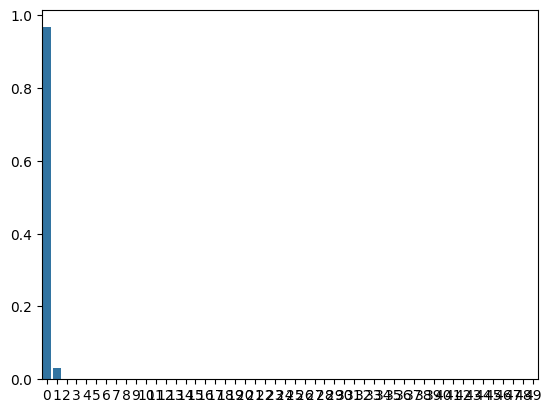

In [18]:
sns.barplot(inc_PCA.explained_variance_ratio_)

In [19]:
pc1_component = pd.DataFrame(
    {
        "var": inc_PCA.feature_names_in_,
        "pc1_contribution": inc_PCA.components_[0]
    }
)

pc1_component = pc1_component.sort_values("pc1_contribution", ascending=False, key = lambda x: abs(x)).reset_index().drop("index", axis = 1)
pc1_component

,var,pc1_contribution
0,volume,8.164894e-01
1,sell_qty,4.101512e-01
2,buy_qty,4.063382e-01
3,bid_qty,-1.431198e-03
4,ask_qty,-1.376846e-03
...,...,...
847,X263,2.643840e-07
848,X234,2.461840e-07
849,X791,2.011894e-07
850,X347,1.813835e-08


In [20]:
# Use the top 50 features
print(pc1_component.iloc[:50, ]["var"].tolist())

['volume', 'sell_qty', 'buy_qty', 'bid_qty', 'ask_qty', 'X596', 'X594', 'X877', 'X879', 'X597', 'X880', 'X595', 'X878', 'X544', 'X551', 'X558', 'X873', 'X117', 'X565', 'X882', 'X153', 'X123', 'X111', 'X502', 'X495', 'X75', 'X881', 'X509', 'X394', 'X141', 'X147', 'X388', 'X87', 'X99', 'X352', 'X105', 'X876', 'X346', 'X572', 'X451', 'X81', 'X69', 'X452', 'X516', 'X177', 'X480', 'X456', 'X135', 'X883', 'X406']


In [21]:
# Also need to check correlation with target variable
var_label_correlation = []
for i in tqdm(range(pc1_component.shape[0])):
    var = pc1_component.loc[i, "var"]
    var_label_correlation.append(train_df.select(pl.corr(var, "label")).collect().item())
pc1_component["var_label_correlation"] = var_label_correlation
pc1_component

100%|██████████| 852/852 [00:00<00:00, 2054.89it/s]


,var,pc1_contribution,var_label_correlation
0,volume,8.164894e-01,0.008809
1,sell_qty,4.101512e-01,0.011166
2,buy_qty,4.063382e-01,0.005618
3,bid_qty,-1.431198e-03,-0.013220
4,ask_qty,-1.376846e-03,-0.015762
...,...,...,...
847,X263,2.643840e-07,0.012352
848,X234,2.461840e-07,0.004803
849,X791,2.011894e-07,0.001805
850,X347,1.813835e-08,-0.010130


In [22]:
pc1_component.sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

,var,pc1_contribution,var_label_correlation
430,X21,0.000022,0.069401
416,X20,0.000024,0.067667
219,X28,0.000049,0.064092
496,X863,-0.000017,0.064057
202,X29,0.000052,0.062339
...,...,...,...
447,X795,-0.000021,-0.000185
265,X170,-0.000042,0.000120
121,X475,0.000079,-0.000063
13,X544,-0.000322,-0.000042


In [23]:
pc1_component["pc1_contribution_rnk"] = pc1_component["pc1_contribution"].abs().rank(method = "min", ascending=False)
pc1_component["var_label_correlation_rnk"] = pc1_component["var_label_correlation"].abs().rank(method = "min", ascending=False)
pc1_component["average_rnk"] = (pc1_component["pc1_contribution_rnk"] + pc1_component["var_label_correlation_rnk"]) / 2
pc1_component

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,volume,8.164894e-01,0.008809,1.0,603.0,302.0
1,sell_qty,4.101512e-01,0.011166,2.0,538.0,270.0
2,buy_qty,4.063382e-01,0.005618,3.0,697.0,350.0
3,bid_qty,-1.431198e-03,-0.013220,4.0,478.0,241.0
4,ask_qty,-1.376846e-03,-0.015762,5.0,402.0,203.5
...,...,...,...,...,...,...
847,X263,2.643840e-07,0.012352,848.0,502.0,675.0
848,X234,2.461840e-07,0.004803,849.0,722.0,785.5
849,X791,2.011894e-07,0.001805,850.0,804.0,827.0
850,X347,1.813835e-08,-0.010130,851.0,571.0,711.0


In [24]:
popular_var = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]
pc1_component[pc1_component["var"].isin(popular_var)]

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,volume,0.816489,0.008809,1.0,603.0,302.0
1,sell_qty,0.410151,0.011166,2.0,538.0,270.0
2,buy_qty,0.406338,0.005618,3.0,697.0,350.0
3,bid_qty,-0.001431,-0.013220,4.0,478.0,241.0
4,ask_qty,-0.001377,-0.015762,5.0,402.0,203.5
131,X345,-0.000076,-0.011439,132.0,527.0,329.5
165,X137,-0.000060,-0.044290,166.0,51.0,108.5
186,X862,0.000057,0.040828,187.0,65.0,126.0
329,X344,0.000032,-0.009061,330.0,597.0,463.5
354,X855,0.000029,0.037702,355.0,88.0,221.5


In [25]:
pc1_component = pc1_component.sort_values("average_rnk").reset_index().drop("index", axis = 1)
pc1_component

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,X473,1.494225e-04,0.040200,54.0,73.0,63.5
1,X451,1.803425e-04,0.035329,40.0,106.0,73.0
2,X111,-2.361445e-04,0.033087,23.0,126.0,74.5
3,X153,-2.469401e-04,0.032990,21.0,128.0,74.5
4,X205,1.427800e-04,0.036817,59.0,97.0,78.0
...,...,...,...,...,...,...
847,X101,-1.208350e-06,-0.001161,827.0,817.0,822.0
848,X78,1.253920e-06,0.000942,826.0,823.0,824.5
849,X791,2.011894e-07,0.001805,850.0,804.0,827.0
850,X790,-6.532218e-07,-0.001051,840.0,820.0,830.0


In [26]:
best_pc1_contribution = pc1_component[pc1_component["pc1_contribution_rnk"] <= 100]["var"].tolist()
with open("features/best_pc1_contribution.pkl", "wb") as f:
    pickle.dump(best_pc1_contribution, f)

In [27]:
best_label_correlation = pc1_component[pc1_component["var_label_correlation_rnk"] <= 100]["var"].tolist()
with open("features/best_label_correlation.pkl", "wb") as f:
    pickle.dump(best_label_correlation, f)

In [28]:
best_overall = (pc1_component.loc[:50, "var"].to_list())
best_overall.extend(["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"])
with open("features/best_overall.pkl", "wb") as f:
    pickle.dump(best_overall, f)

In [29]:
# Incremental PCA
inc_PCA = IncrementalPCA(n_components = 50)

# fitting a batch every turn
n_rows = train_df.select("bid_qty").count().collect()[0, 0]
batch_size = 50000
for i in tqdm(range(0, n_rows, batch_size)):
    length = min(n_rows - i, batch_size)
    train_df_batch = train_df.select(best_label_correlation).slice(offset = i, length = length).collect()
    inc_PCA.partial_fit(train_df_batch)

100%|██████████| 11/11 [00:02<00:00,  4.12it/s]


<Axes: >

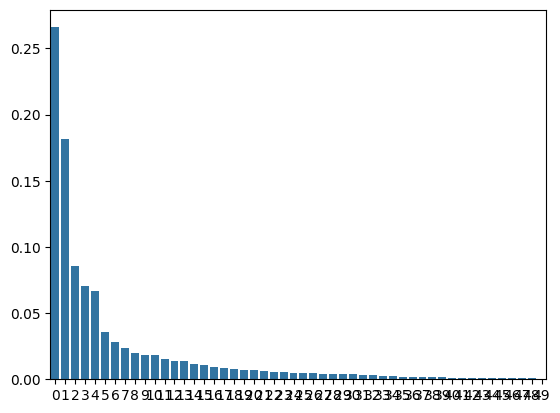

In [30]:
sns.barplot(inc_PCA.explained_variance_ratio_)

<Axes: >

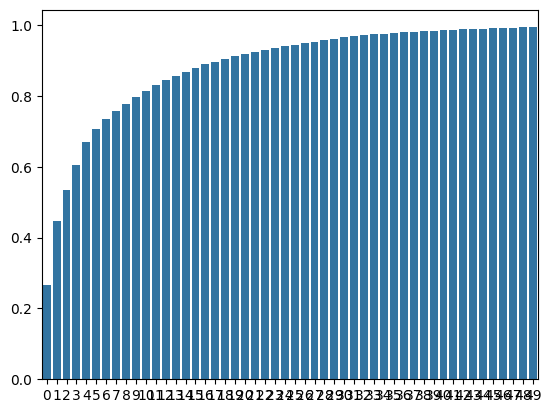

In [31]:
sns.barplot(np.cumsum(inc_PCA.explained_variance_ratio_))

In [32]:
# count appearance in top k factors in top 5 components
top_contribution = {}

for i in range(4):
    temp = pd.DataFrame(
        {
            "var": inc_PCA.feature_names_in_,
            "pc1_contribution": inc_PCA.components_[i]
        }
    )
    temp_lst = temp.sort_values("pc1_contribution", ascending=False, key = lambda x: abs(x)).iloc[:10, ]["var"].tolist()
    for var in temp_lst:
        top_contribution[var] = top_contribution.get(var, 0) + inc_PCA.explained_variance_ratio_[i]
top_contribution = pd.DataFrame(
    {
        "var": list(top_contribution.keys()),
        "contribution": list(top_contribution.values())
    }
).sort_values("contribution", ascending=False).reset_index().drop("index", axis = 1)
top_contribution.loc[:20,]

,var,contribution
0,X217,0.447664
1,X868,0.447664
2,X473,0.422322
3,X466,0.336577
4,X218,0.266039
5,X225,0.266039
6,X137,0.266039
7,X89,0.266039
8,X169,0.266039
9,X224,0.266039


Analyze interesting features from initial modeling

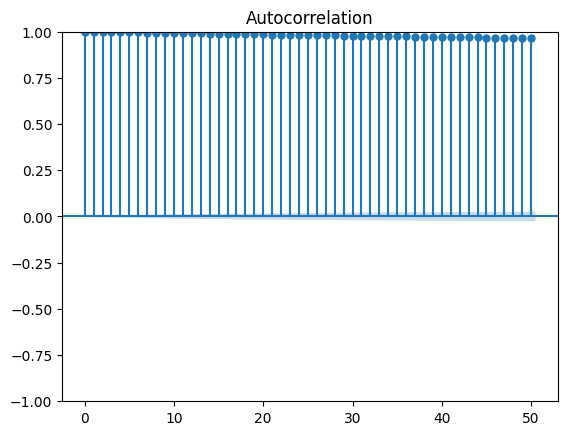

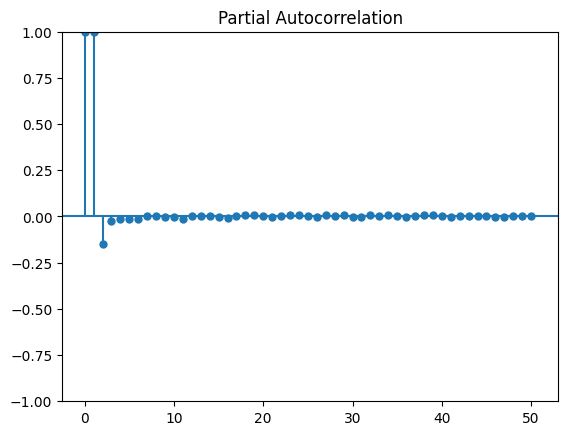

In [33]:
plot_acf(train_df.select("X198").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X198").collect().to_numpy(), lags=50)
plt.show()

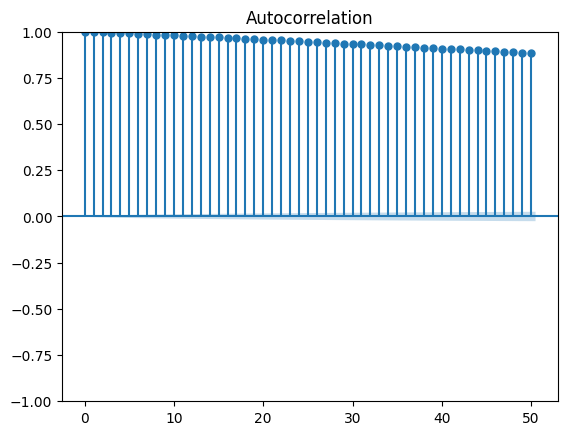

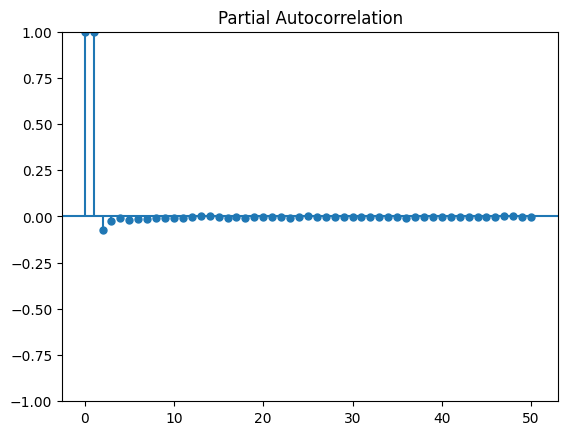

In [34]:
plot_acf(train_df.select("X598").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X598").collect().to_numpy(), lags=50)
plt.show()

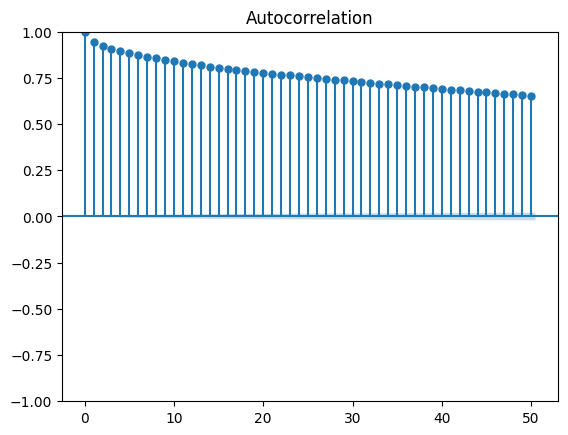

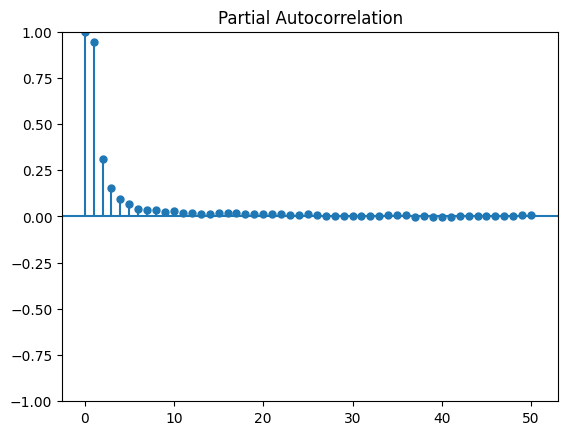

In [35]:
plot_acf(train_df.select("X863").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X863").collect().to_numpy(), lags=50)
plt.show()

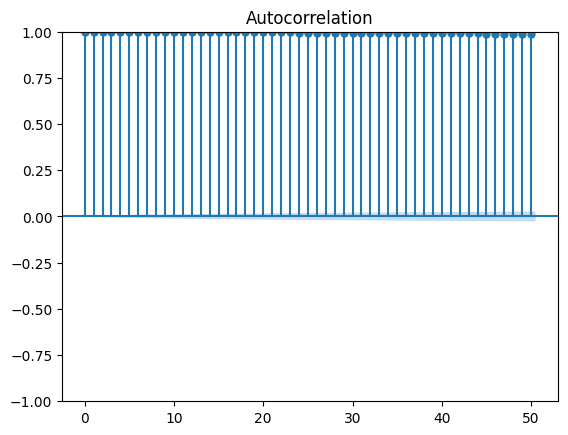

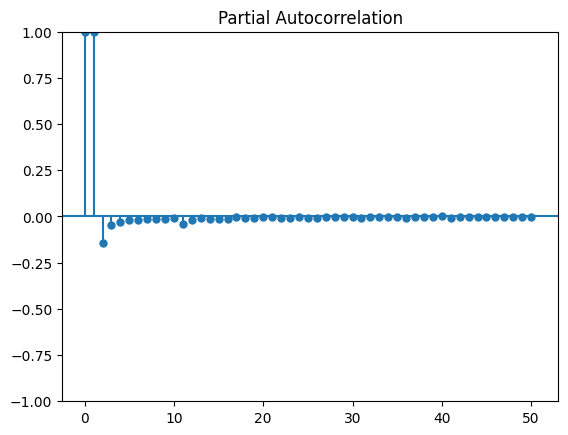

In [36]:
plot_acf(train_df.select("X466").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X466").collect().to_numpy(), lags=50)
plt.show()

Try to cluster the features to see how many groups we have

In [37]:
X = train_df.collect().to_numpy().T
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
distance_matrix = pdist(X, metric='euclidean')  
linkage_matrix = linkage(distance_matrix, method='median') 

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/2747204979.py:2: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  dendrogram(linkage_matrix, orientation="right", labels = list(train_df.schema.keys()), leaf_font_size=8)


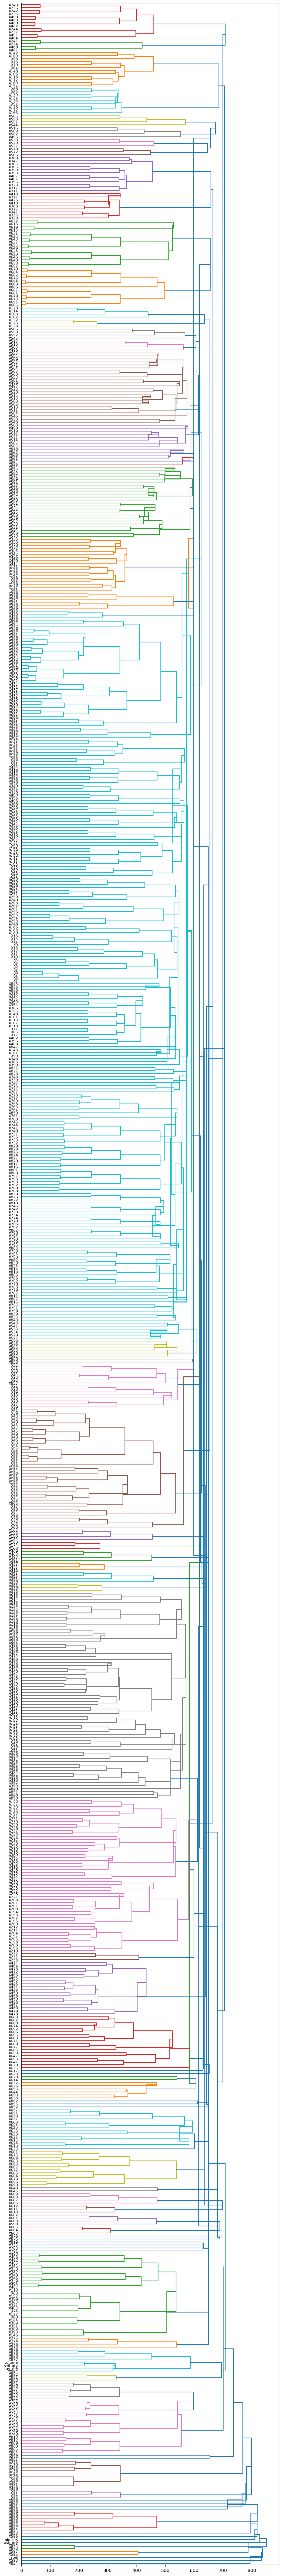

In [38]:
plt.figure(figsize=(10, 100))
dendrogram(linkage_matrix, orientation="right", labels = list(train_df.schema.keys()), leaf_font_size=8)
plt.show()

In [39]:
# Cut the dendrogram to form k clusters
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
}).sort_values("cluster").reset_index(drop=True)
clusters_df

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/991944863.py:4: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  "var": list(train_df.schema.keys()),


,var,cluster
0,X595,1
1,X597,1
2,X873,2
3,X874,2
4,X886,3
...,...,...
848,bid_qty,43
849,ask_qty,44
850,label,45
851,X593,46


In [40]:
clusters_df["cluster"].value_counts()

cluster
25    569
11     28
7      24
24     20
27     16
21     14
26     13
34     12
20     12
36     12
29     12
5      10
33      9
28      9
23      8
9       8
3       7
30      6
18      4
31      4
32      4
35      4
12      4
10      4
16      4
17      3
22      3
15      3
8       3
4       3
1       2
2       2
19      2
6       2
14      1
13      1
37      1
38      1
39      1
40      1
41      1
42      1
43      1
44      1
45      1
46      1
47      1
Name: count, dtype: int64

In [41]:
pc1_component[pc1_component["var"].isin(clusters_df[clusters_df["cluster"] == 25]["var"].to_list())].sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
126,X21,0.000022,0.069401,431.0,1.0,216.0
119,X20,0.000024,0.067667,417.0,2.0,209.5
22,X28,0.000049,0.064092,220.0,3.0,111.5
16,X29,0.000052,0.062339,203.0,5.0,104.0
28,X19,0.000046,0.062293,235.0,6.0,120.5
...,...,...,...,...,...,...
630,X575,-0.000041,-0.000360,269.0,841.0,555.0
834,X9,-0.000007,-0.000286,688.0,844.0,766.0
838,X541,-0.000005,-0.000273,722.0,845.0,783.5
730,X795,-0.000021,-0.000185,448.0,848.0,648.0


In [42]:
pc1_component[pc1_component["var"].isin(clusters_df[clusters_df["cluster"] == 11]["var"].to_list())].sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
197,X238,0.000024,0.032881,416.0,131.0,273.5
193,X245,0.000025,0.032081,399.0,141.0,270.0
212,X246,0.000024,0.031458,419.0,155.0,287.0
236,X239,0.000021,0.030653,446.0,165.0,305.5
595,X247,0.000002,0.024211,804.0,257.0,530.5
641,X240,-0.000001,0.022108,834.0,295.0,564.5
717,X485,0.000001,0.014402,831.0,444.0,637.5
671,X492,0.000004,0.014357,748.0,446.0,597.0
610,X68,0.000010,0.013250,614.0,475.0,544.5
611,X110,0.000010,0.013250,614.0,475.0,544.5


In [43]:
pc1_component[pc1_component["var"].isin(clusters_df[clusters_df["cluster"] == 47]["var"].to_list())].sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
551,X854,0.000033,-0.006139,320.0,684.0,502.0


Test important features on lags with other columns to reverse-engineer anonymized features

In [44]:
train_df = train_df.with_columns(
    # interaction features
    (pl.col("bid_qty") * pl.col("ask_qty")).alias("bid_ask_interaction"),
    (pl.col("bid_qty") * pl.col("buy_qty")).alias("bid_buy_interaction"),
    (pl.col("bid_qty") * pl.col("sell_qty")).alias("bid_sell_interaction"),
    (pl.col("ask_qty") * pl.col("buy_qty")).alias("ask_buy_interaction"),
    (pl.col("ask_qty") * pl.col("sell_qty")).alias("ask_sell_interaction"),
    (pl.col("buy_qty") * pl.col("sell_qty")).alias("buy_sell_interaction"),

    # spread features
    ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("ask_qty") + pl.col("bid_qty")) + 1e-8).alias("spread_indicator"),

    # volume weighted features
    (pl.col("buy_qty") * pl.col("volume")).alias("volume_weighted_buy"),
    (pl.col("sell_qty") * pl.col("volume")).alias("volume_weighted_sell"),
    (pl.col("bid_qty") * pl.col("volume")).alias("volume_weighted_bid"),
    (pl.col("ask_qty") * pl.col("volume")).alias("volume_weighted_ask"),

    # buy/sell and bid/ask ratios
    (pl.col("buy_qty") / (pl.col("sell_qty") + 1e-8)).alias("buy_sell_ratio"),
    (pl.col("bid_qty") / (pl.col("ask_qty") + 1e-8)).alias("bid_ask_ratio"),

    # order flow imbalance
    ((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)).alias("order_flow_imbalance"),

    # buying and selling pressure
    (pl.col("buy_qty") / (pl.col("volume") + 1e-8)).alias("buying_pressure"),
    (pl.col("sell_qty") / (pl.col("volume") + 1e-8)).alias("selling_pressure"),

    # liquidity features
    (pl.col("bid_qty") + pl.col("ask_qty")).alias("total_liquidity"),
    ((pl.col("bid_qty") - pl.col("ask_qty")) / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("liquidity_imbalance"),
    ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("volume") + 1e-8)).alias("relative_spread"),

    # trade related features (size, intensity, flow)
    ((pl.col("buy_qty") + pl.col("sell_qty")) / (pl.col("volume") + 1e-8)).alias("trade_intensity"),
    (pl.col("volume") / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("avg_trade_size"),
    ((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("net_trade_flow"),

    # volume features in market + how market is working wrt to volume 
    ((pl.col("bid_qty") + pl.col("ask_qty")) / (pl.col("volume") + 1e-8)).alias("depth_ratio"),
    ((pl.col("buy_qty") + pl.col("sell_qty")) / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("volume_participation"),
    (pl.col("volume") * (pl.col("bid_qty") + pl.col("ask_qty"))).alias("market_activity"),

    # spread proxy and realized vol proxy
    ((pl.col("buy_qty") - pl.col("sell_qty")).abs() / (pl.col("volume") + 1e-8)).alias("effective_spread_proxy"),
    (((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)) * pl.col("volume")).alias("realized_volatility_proxy"),

    # normalized buy/sell volume
    (pl.col("buy_qty") / (pl.col("bid_qty") + 1e-8)).alias("normalized_buy_volume"),
    (pl.col("sell_qty") / (pl.col("ask_qty") + 1e-8)).alias("normalized_sell_volume"),

    # imbalance and spread interaction
    (((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)) * ((pl.col("bid_qty") + pl.col("ask_qty")) / (pl.col("volume") + 1e-8))).alias("liquidity_adjusted_imbalance"),
    ((pl.col("buy_qty") / (pl.col("volume") + 1e-8)) * ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("ask_qty") + pl.col("bid_qty")) + 1e-8)).alias("pressure_spread_interaction"),

    # trade direction ratio, net buying volume, bid/ask skew
    (pl.col("buy_qty") / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("trade_direction_ratio"),
    (pl.col("buy_qty") - pl.col("sell_qty")).alias("net_buy_volume"),
    (pl.col("bid_qty") / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("bid_skew"),
    (pl.col("ask_qty") / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("ask_skew")
)

train_df = train_df.fill_nan(0).fill_null(0)

In [45]:
max_correlation = 0
max_abs_correlation = 0
feature = None
for col in train_df.schema.keys():
    if "X" not in col:
        corr = train_df.with_columns(
            pl.col("X466").rolling_mean(window_size=2).shift(1).alias("X466_rolling_2")
        ).with_row_index("row_inx").select(pl.corr("X466_rolling_2", col)).collect().item()
        if abs(corr) > max_abs_correlation:
            max_abs_correlation = abs(corr)
            max_correlation = corr
            feature = col
print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/787709061.py:4: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


total_liquidity -0.18555983095476353 0.18555983095476353


In [46]:
max_correlation = 0
max_abs_correlation = 0
feature = None
for col in train_df.schema.keys():
    if "X" not in col:
        corr = train_df.with_columns(
            pl.col("X198").rolling_mean(window_size=2).shift(1).alias("X198_rolling_2")
        ).with_row_index("row_inx").select(pl.corr("X198_rolling_2", col)).collect().item()
        if abs(corr) > max_abs_correlation:
            max_abs_correlation = abs(corr)
            max_correlation = corr
            feature = col
print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/1217563903.py:4: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


buy_qty 0.07390064542897076 0.07390064542897076


In [47]:
max_correlation = 0
max_abs_correlation = 0
feature = None
for col in train_df.schema.keys():
    if "X" not in col:
        corr = train_df.with_columns(
            pl.col("X598").rolling_mean(window_size=1).shift(1).alias("X598_rolling_1")
        ).with_row_index("row_inx").select(pl.corr("X598_rolling_1", col)).collect().item()
        if abs(corr) > max_abs_correlation:
            max_abs_correlation = abs(corr)
            max_correlation = corr
            feature = col
print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_16873/2256874444.py:4: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


label 0.05469037452172282 0.05469037452172282


In [48]:
# strong_threshold = 0.3
# anonymized_features = [c for c in list(train_df.schema.keys()) if "X" in c]
# known_features = [c for c in list(train_df.schema.keys()) if "X" not in c]
# for col1 in tqdm(anonymized_features):
#     for lag in range(1, 6):
#         max_correlation = 0
#         max_abs_correlation = 0
#         feature = None
#         for col2 in known_features:
#             corr = train_df.with_columns(
#                 pl.col(col1).rolling_mean(window_size=lag).shift(1).alias(f"{col1}_rolling_{lag}")
#             ).with_row_index("row_inx").select(pl.corr(f"{col1}_rolling_{lag}", col2)).collect().item()
#             if abs(corr) > max_abs_correlation:
#                 max_abs_correlation = abs(corr)
#                 max_correlation = corr
#                 feature = col2
#         if max_abs_correlation >= strong_threshold:
#             print(col1, lag, feature, max_correlation, max_abs_correlation)